In [1]:
from PCB_class import PCB
from Component_class import Component, Pin
from Plots import plot_pcb

from Genetic_algorithms import generate_random_population, crossover, mutate_rotation, mutate_position



In [2]:
pin1_c1 = Pin(id="P1", relative_x=-5, relative_y=0)
pin2_c1 = Pin(id="P2", relative_x=5, relative_y=0)

comp1 = Component(
    id="C1",
    shape="rect",
    size_x=20, size_y=10,
    pins=[pin1_c1, pin2_c1],
    position=(21, 21),
    temp_gradient_params=(100, 15)
)

pin3_c2 = Pin(id="P3", relative_x=0, relative_y=-3)
pin4_c2 = Pin(id="P4", relative_x=0, relative_y=3)

comp2 = Component(
    id="C2",
    shape="circle",
    size_x=15, size_y=15,
    pins=[pin3_c2, pin4_c2],
    position=(20, 20),
    temp_gradient_params=(100, 15)
)

In [3]:
links = [
        (("C1", "P2"), ("C2", "P3"))   # comp1.pin2 <--> comp2.pin3
    ]

[('C1', 'C2', 136.69346059085066)]
[('C1', 'C2', 15.829596324945152)]
[]


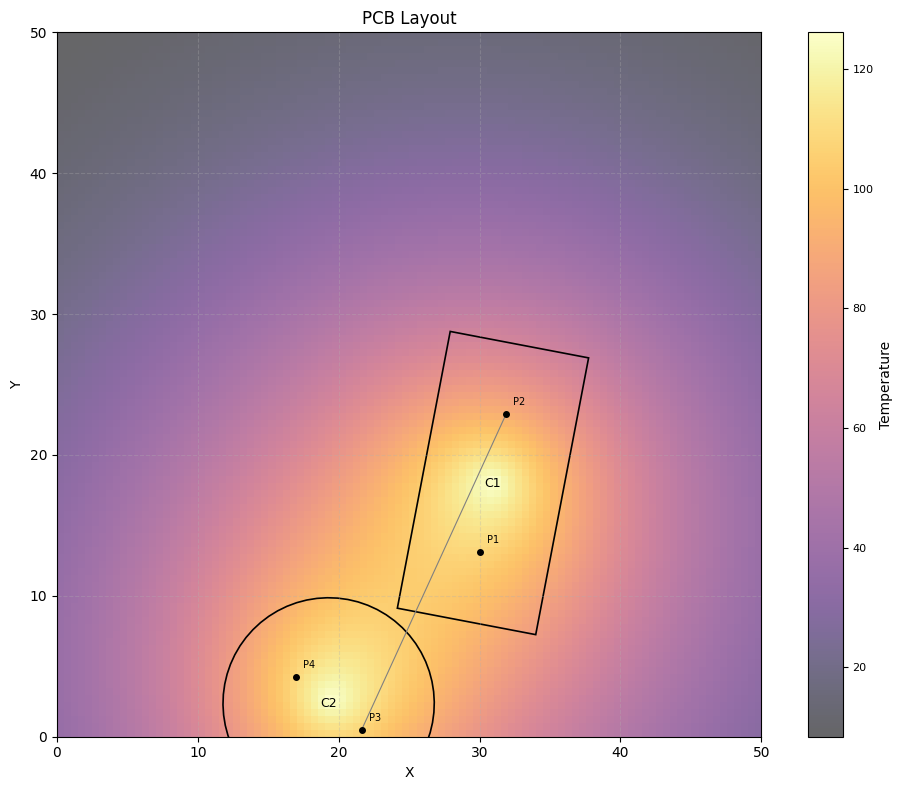

In [4]:
pcb1 = PCB(
        max_width=50,
        max_height=50,
        components=[comp1, comp2],
        links=links
    )
pcb1.random_placement()
pcb1.resolve_conflicts(max_iterations=100)
plot_pcb(pcb1, show_temp=True)


In [5]:
a = generate_random_population(pcb1, 10)

[('C1', 'C2', 45.72884798031547)]
[]
[('C1', 'C2', 4.428251314476627)]
[]
[('C1', 'C2', 69.86759973851728)]
[]
[('C1', 'C2', 10.772669287013525)]
[]
[]
[]
[('C1', 'C2', 27.324671960912248)]
[]
[]
[('C1', 'C2', 14.257237184383238)]
[]
[]


In [8]:
child1, child2 = crossover(a[0], a[1], 1)

[]
[('C1', 'C2', 32.91786886350321)]
[]


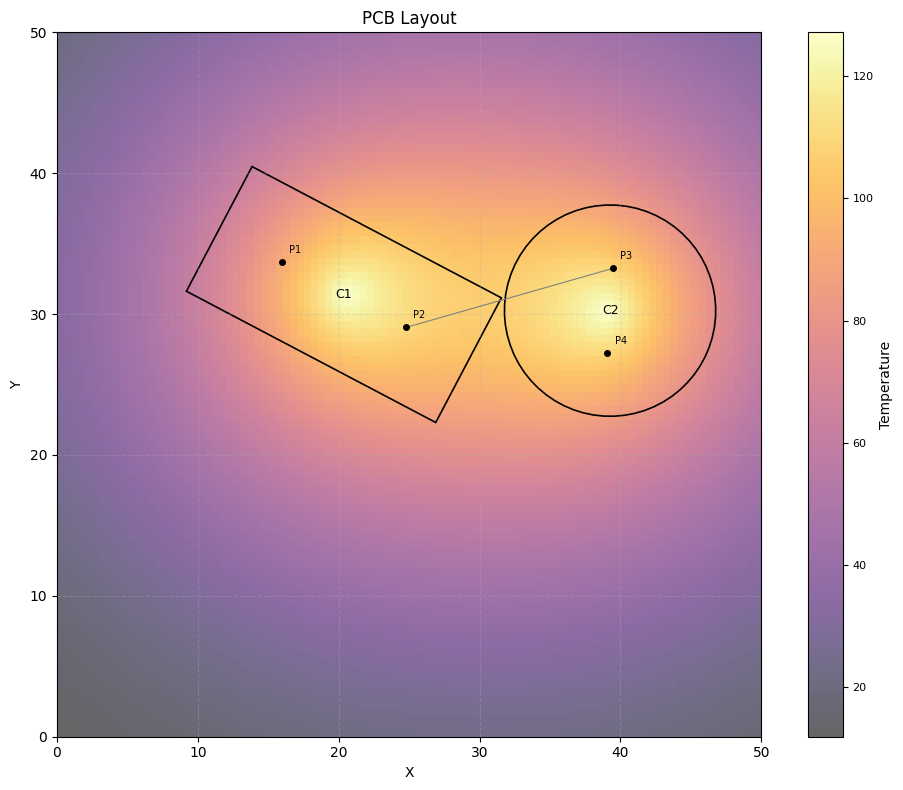

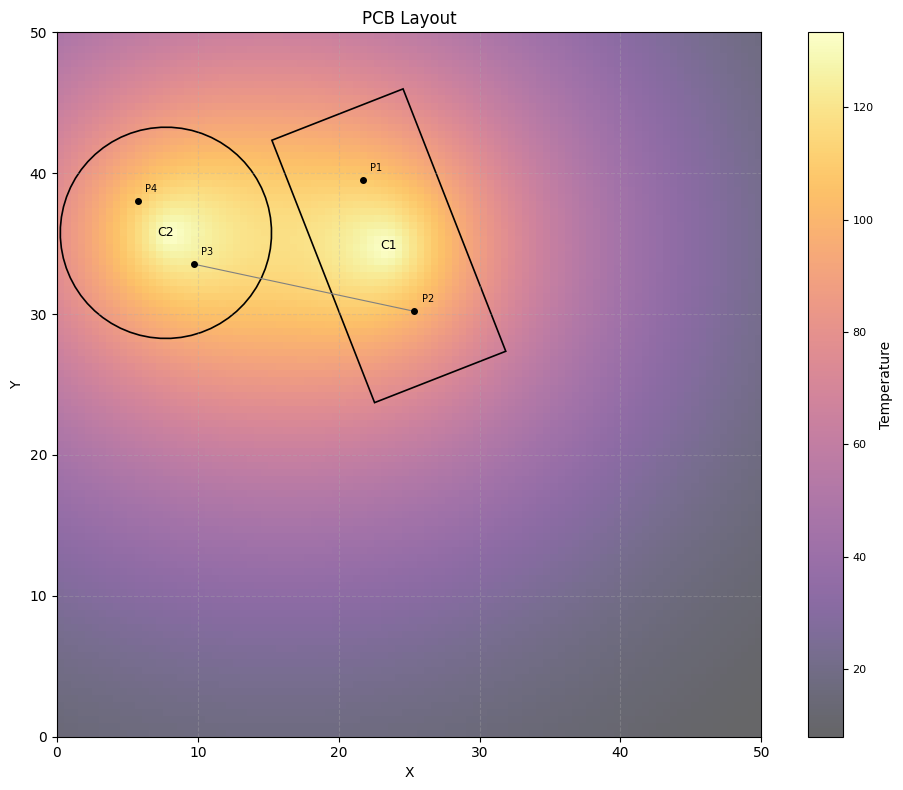

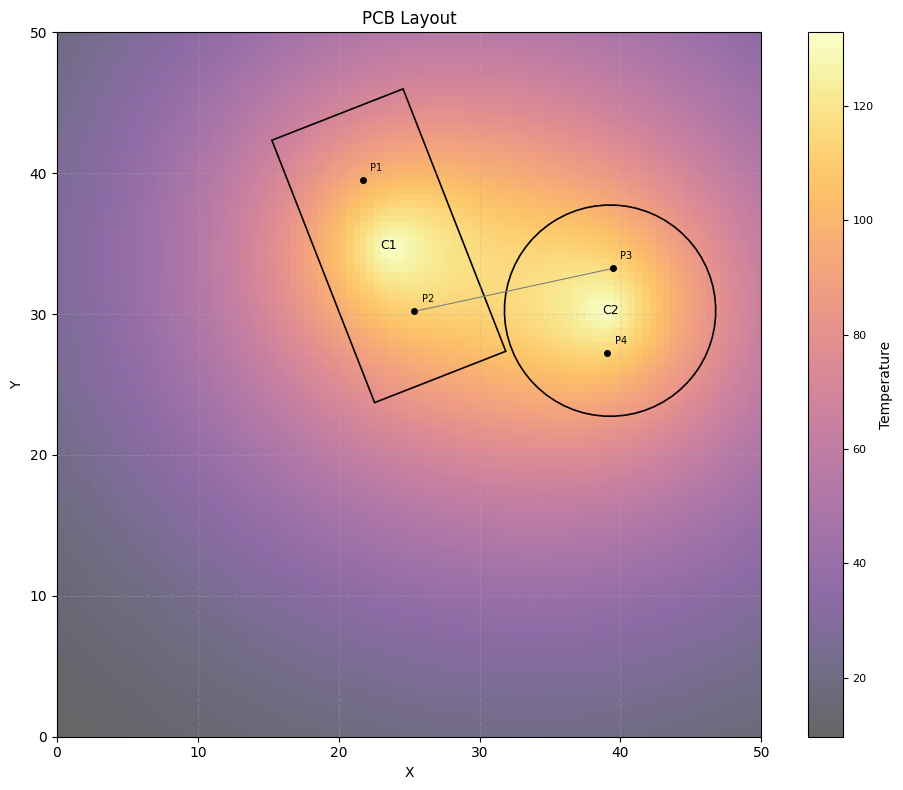

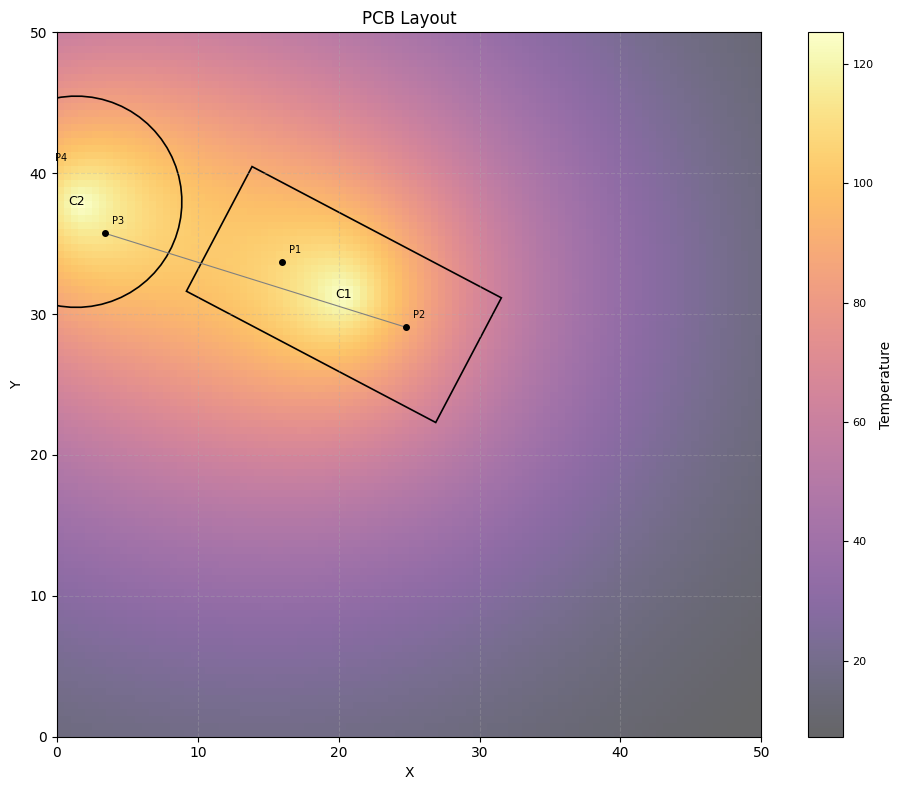

In [9]:
plot_pcb(a[0], show_temp=True)
plot_pcb(a[1], show_temp=True)
plot_pcb(child1, show_temp=True)
plot_pcb(child2, show_temp=True)
